In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import glob
from pytz import all_timezones
from scipy import stats

In [2]:
########### BEGIN Building PANDORA DataFrames

In [3]:
# Pandas dataframe from pandora data
npz = np.load('PandoraAltz.npz',allow_pickle=True)
df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

In [4]:
# Filtered data by qflag 0,10
options = [0,10] 
rslt_df = df[df['qflag'].isin(options)] 
#localization of dataframe so that datetime is UTC and not naive
dtimeutc=rslt_df.dtime.dt.tz_localize('Etc/UTC')
dtimelocal=dtimeutc.dt.tz_convert('Etc/GMT+6')
dflocal = rslt_df.assign(dtime=dtimelocal)
tslocal = dflocal.set_index('dtime')
### changing dobson units
tsloc_molcm2=tslocal.assign(ozone=tslocal.ozone*2.6868e16)
## grouping by hour
tslocmean = tsloc_molcm2.ozone.groupby(tslocal.index.hour).mean()
tslocstd=tsloc_molcm2.ozone.groupby(tslocal.index.hour).std()
## grouping by month
tslocmeanmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).mean()
tslocstdmt = tsloc_molcm2.ozone.groupby(tslocal.index.month).std()


In [5]:
########### END Building PANDORA DataFrames
########### BEGIN Building MERRA2 DataFrames

In [6]:
# Pandas DataFrame from MERRA2 data
# data is stored in folders by year, filenames are O3_YYYY_MM_DD_HH.txt
years = np.arange(2012,2020)
date=[]
O3=[]
O3trop=[]
O3strat=[]
#testcount = 0
for year in years:
    merrapath = 'D:\\CCA\\PANDONIA\\O3fromMERRA2\\'+'%i*\\' % (year) + '*.*'
    filelist = glob.glob(merrapath)
    #testcount = testcount + len(filelist)
    #print(testcount)
    for filename in filelist:
        tempdf = pd.read_csv(filename)
        tempdf.set_axis(['fixedP','fixedO3','modelP','modelO3'], axis=1, inplace=True)
        
        ############################ converting pressure to altitude
        tdfa = tempdf[tempdf['modelP'] <= 226.32].assign(modelP=((1.73-np.log(tempdf.modelP/226.32))/0.000157))
        tdfb = tempdf[tempdf['modelP'] > 226.32].assign(modelP=((1-(tempdf.modelP/1013.25)**(1/5.25588))/2.25577e-5))
        tempdf2=tdfa.append(tdfb)
        tempdf2.set_axis(['fixedP','fixedO3','modelAlt','modelO3'], axis=1, inplace=True)
        
        ############################ altitude difference series
        altdiff=tempdf2.modelAlt.diff()
        altdiff=altdiff.replace(altdiff[0],altdiff[1])
        altdiff=-altdiff
        
        ############################ converting altitude to T in degC
        tdfa = tempdf2[tempdf2['modelAlt'] <= 11000].assign(modelAlt=(15.04-0.00649*tempdf2.modelAlt))
        tdfb = tempdf2[tempdf2['modelAlt'] > 11000].assign(modelAlt=-56.46)
        tempdf3=tdfb.append(tdfa)
        tempdf3.set_axis(['fixedP','fixedO3','modelT','modelO3'], axis=1, inplace=True)
        
        ############################ calculating air number density and ozone number density
        nair = tempdf.modelP*100*6.022e23/(8.314463*(tempdf3.modelT+273.15))
        tempdf4 = tempdf2.assign(modelO3=tempdf3.modelO3*nair)
        tempdf5 = tempdf4.assign(modelO3=(tempdf4.modelO3*altdiff)/10000)
        
        ############################ calculating column density
        columnO3=tempdf5.modelO3.sum()
        columnO3trop=tempdf5[tempdf2['modelAlt'] <= 11000].modelO3.sum()
        columnO3strat=tempdf5[tempdf2['modelAlt'] > 11000].modelO3.sum()
        
        ############################ extracting datetime from filename and appending
        time=dt.datetime.strptime(filename[-17:-4],'%Y_%m_%d_%H')
        date.append(time)
        O3.append(columnO3)
        O3trop.append(columnO3trop)
        O3strat.append(columnO3strat)
        
merradf = pd.DataFrame(data={"date": date, "ozone": O3})
merradftrop= pd.DataFrame(data={"date":date,"ozone": O3trop})
merradfstrat= pd.DataFrame(data={"date":date,"ozone": O3strat})


In [17]:
# Monthly MERRA
#total
tsmerra = merradf.set_index('date')
tsmerramm = tsmerra.ozone.resample('M').mean()
tsmerrameanmt = tsmerramm.groupby(tsmerramm.index.month).mean()
tsmerrasm = tsmerra.ozone.resample('M').std()
tsmerrastdmt = tsmerrasm.groupby(tsmerrasm.index.month).std()
#tropospheric
tsmerratrop = merradftrop.set_index('date')
tsmerrammtrop = tsmerratrop.ozone.resample('M').mean()
tsmerrameanmttrop = tsmerrammtrop.groupby(tsmerrammtrop.index.month).mean()
tsmerrasmtrop = tsmerratrop.ozone.resample('M').std()
tsmerrastdmttrop = tsmerrasmtrop.groupby(tsmerrasmtrop.index.month).std()
#stratospheric
tsmerrastrat = merradfstrat.set_index('date')
tsmerrammstrat = tsmerrastrat.ozone.resample('M').mean()
tsmerrameanmtstrat = tsmerrammstrat.groupby(tsmerrammstrat.index.month).mean()
tsmerrasmstrat = tsmerrastrat.ozone.resample('M').std()
tsmerrastdmtstrat = tsmerrasmstrat.groupby(tsmerrasmstrat.index.month).std()

In [8]:
# Hourly MERRA
#total
tsmerra = merradf.set_index('date')
tsmerramean = tsmerra.ozone.groupby(tsmerra.index.hour).mean()
tsmerrastd = tsmerra.ozone.groupby(tsmerra.index.hour).std()
#tropospheric
tsmerratrop = merradftrop.set_index('date')
tsmerrameantrop = tsmerratrop.ozone.groupby(tsmerratrop.index.hour).mean()
tsmerrastdtrop = tsmerratrop.ozone.groupby(tsmerratrop.index.hour).std()
#stratospheric
tsmerrastrat = merradfstrat.set_index('date')
tsmerrameanstrat = tsmerrastrat.ozone.groupby(tsmerrastrat.index.hour).mean()
tsmerrastdstrat = tsmerrastrat.ozone.groupby(tsmerrastrat.index.hour).std()

In [9]:
########### END Building MERRA2 DataFrames
########### BEGIN Building FTIR DataFrames

In [11]:
#total
date=[]
O3=[]
tempdf = pd.read_csv('D:\\CCA\\PANDONIA\\trop-total_O3\\totalO3.txt',sep='\t',header=None)
tempdf.set_axis(['date','ozone'], axis=1, inplace=True)
for ii,ele in enumerate(tempdf.date):
    date.append(dt.datetime.strptime(ele,'%Y-%m-%d:%H'))
    O3.append(tempdf.ozone[ii])
ftirdf = pd.DataFrame(data={"date": date, "ozone": O3})
#tropospheric
date=[]
O3trop=[]
tempdf = pd.read_csv('D:\\CCA\\PANDONIA\\trop-total_O3\\tropO3.txt',sep='\t',header=None)
tempdf.set_axis(['date','ozone'], axis=1, inplace=True)
for ii,ele in enumerate(tempdf.date):
    date.append(dt.datetime.strptime(ele,'%Y-%m-%d:%H'))
    O3trop.append(tempdf.ozone[ii])
ftirdftrop = pd.DataFrame(data={"date": date, "ozone": O3trop})

In [21]:
#Hourly FTIR
#total
tsftir = ftirdf.set_index('date')
tsftirmean = tsftir.ozone.groupby(tsftir.index.hour).mean()
tsftirstd = tsftir.ozone.groupby(tsftir.index.hour).std()
#tropospheric
tsftirtrop = ftirdftrop.set_index('date')
tsftirmeantrop = tsftirtrop.ozone.groupby(tsftir.index.hour).mean()
tsftirstdtrop = tsftirtrop.ozone.groupby(tsftir.index.hour).std()
#Monthly FTIR
#total
tsftirmeanmt = tsftir.ozone.groupby(tsftir.index.month).mean()
tsftirstdmt = tsftir.ozone.groupby(tsftir.index.month).std()
#tropospheric
tsftirmeanmttrop = tsftirtrop.ozone.groupby(tsftir.index.month).mean()
tsftirstdmttrop = tsftirtrop.ozone.groupby(tsftir.index.month).std()

In [13]:
########### END Building FTIR DataFrames

In [14]:
## simple plotting with error - DEPRECATED
#ax = tslocmeanmt.plot(figsize=(10,6),title='Ozone yearly profile',ylabel='molecule/cm$^2$',yerr=tslocstdmt,capsize=4,fontsize=12)
#tsmerramm2.plot(figsize=(10,6),xlabel='Month',yerr=tsmerrastdmt,capsize=4,fontsize=12)

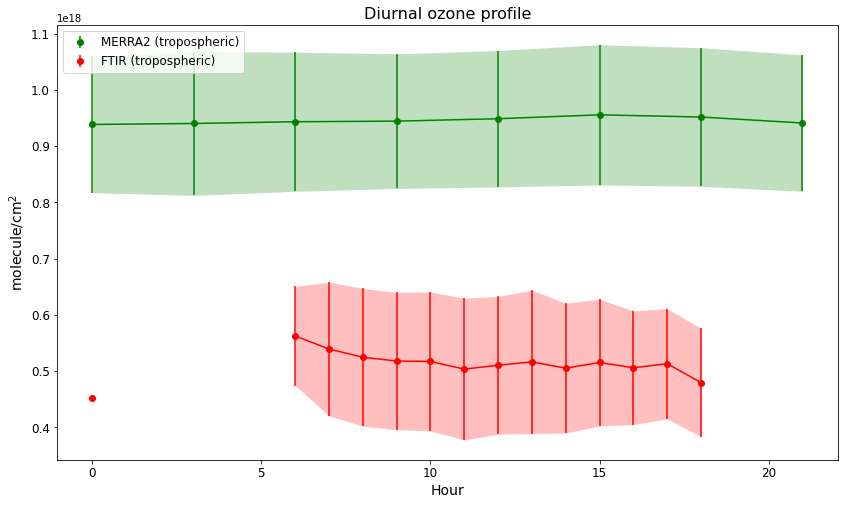

In [29]:
## pyplot plotting
# PANDONIA = loc, MERRA2 = merra, FTIR = ftir
# varname format = ts + source + mean/std + hourly(none)/monthly(mt) + total(none)/trop/strat 
# e.g. tsmerrameanmttrop

# Variable definition
x1 = tslocmean.index
y1 = tslocmean
err1 = tslocstd
x2 = tsmerrameantrop.index
y2 = tsmerrameantrop
err2 = tsmerrastdtrop
x3 = tsftirmeantrop.index 
y3 = tsftirmeantrop
err3 = tsftirstdtrop

### INITIALIZATION
fig, ax1 = plt.subplots(figsize=(14, 8))

## line and stdev
#ax1.plot(x1, y1, '-b')
#ax1.fill_between(x1, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
ax1.plot(x2, y2, '-g')
ax1.fill_between(x2, y2-err2, y2+err2,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
ax1.plot(x3, y3, '-r')
ax1.fill_between(x3, y3-err3, y3+err3,alpha=.25, edgecolor='#3F7F4C', facecolor='r',linewidth=0)

## LABEL, marker and errorbar
#ax1.errorbar(x1, y1, yerr=err1, fmt='bo', label='Pandonia Altzomoni (total)')
ax1.errorbar(x2, y2, yerr=err2, fmt='go', label='MERRA2 (tropospheric)')
ax1.errorbar(x3, y3, yerr=err3, fmt='ro', label='FTIR (tropospheric)')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax1.set_xlabel('Hour',size=14)
ax1.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_title("Diurnal ozone profile",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)

## SAVEFIG
#plt.savefig('D:\\CCA\\PANDONIA\\diurnalO3PanAltzMERRA.png')

In [ ]:
################## TESTING AFTER THIS LINE

In [ ]:
testdf = pd.read_csv('D:\\CCA\\PANDONIA\\trop-total_O3\\tropO3.txt',sep='\t',header=None)
testdf.set_axis(['date','tropO3'], axis=1, inplace=True)
testdf

In [ ]:
dt.datetime.strptime(testdf.date[74061],'%Y-%m-%d:%H')

In [ ]:
len(testdf.date)

In [ ]:
for ii,ele in enumerate(testdf.date):
    if (ii%10000)==0:
        print(dt.datetime.strptime(ele,'%Y-%m-%d:%H'))
        print(testdf.tropO3[ii])

In [ ]:
############################# PandoraAltz, PandoraAltzNO2, FTIRAltzTotalO3-LITE

In [2]:
#### Pandora needs qflag filtering
#dtime, ozone
npz = np.load('PandoraALTZ.npz',allow_pickle=True)
dfpano3= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

#dtime, no2
npz = np.load('PandoraAltzNO2.npz',allow_pickle=True)
dfpanno2= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

options = [0,10] 
qf_dfpano3 = dfpano3[dfpano3['qflag'].isin(options)] 
qf_dfpanno2 = dfpanno2[dfpanno2['qflag'].isin(options)] 

########
#time, o3column
npz = np.load('FTIRAltzTotalO3-LITE.npz',allow_pickle=True)
dfftiro3= pd.DataFrame.from_dict({item: npz[item] for item in npz.files})
npz.close()

In [3]:
#timeseries
ftirts=dfftiro3.set_index('time')
pano3ts=qf_dfpano3.set_index('dtime')
panno2ts=qf_dfpanno2.set_index('dtime')

In [4]:
panno2ts

,no2,uncty,no2massf,diffcorr,qflag,sum2iDQ1,sum2iDQ2
dtime,,,,,,,
2019-02-01 15:39:12.000,0.063686,0.001408,1.929,0.0,0,0.0,0.0
2019-02-01 15:40:40.000,0.065188,0.001530,1.914,0.0,0,0.0,0.0
2019-02-01 15:42:05.000,0.064987,0.001842,1.899,0.0,0,0.0,0.0
2019-02-01 15:43:31.000,0.063933,0.004026,1.884,0.0,0,0.0,0.0
2019-02-01 15:44:56.000,0.066786,0.001539,1.870,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...
2021-08-23 16:13:32.400,0.094621,0.002470,1.227,0.0,10,0.0,0.0
2021-08-23 16:13:38.500,0.102320,0.002492,1.227,0.0,10,0.0,0.0
2021-08-23 16:13:44.500,0.100510,0.002673,1.227,0.0,10,0.0,0.0


In [5]:
ftirts_hr_mean=ftirts.resample('H').mean().dropna()
ftirts_hr_std=ftirts.resample('H').std().dropna()
ftirts_hr_mean

,o3column
time,
2012-10-26 20:00:00,251.487015
2012-10-26 21:00:00,250.218338
2012-11-16 13:00:00,241.721863
2012-11-16 14:00:00,241.388550
2012-11-16 16:00:00,241.780365
...,...
2021-07-23 17:00:00,286.913940
2021-07-23 19:00:00,289.091583
2021-07-24 16:00:00,295.316345


In [6]:
tempdic={'ozone':pano3ts.ozone}
panozts=pd.DataFrame(data=tempdic)
panozts_hr_mean=panozts.resample('H').mean().dropna()
panozts_hr_std=panozts.resample('H').mean().dropna()
panozts_hr_mean

,ozone
dtime,
2019-02-01 15:00:00,231.949167
2019-02-01 16:00:00,232.647586
2019-02-01 17:00:00,233.207500
2019-02-01 18:00:00,233.131786
2019-02-03 20:00:00,231.895000
...,...
2021-05-25 14:00:00,258.063000
2021-05-25 15:00:00,256.573000
2021-05-25 16:00:00,253.595000


In [7]:
coinc_hr_mean=pd.merge(ftirts_hr_mean,panozts_hr_mean,left_index=True,right_index=True)
coinc_hr_mean

,o3column,ozone
2019-02-03 21:00:00,249.458405,232.754615
2019-02-03 22:00:00,247.669281,231.934474
2019-02-03 23:00:00,247.462616,229.180000
2019-02-04 14:00:00,247.581940,230.314103
2019-02-04 15:00:00,248.002502,231.433421
...,...,...
2021-05-14 13:00:00,270.329407,252.058750
2021-05-14 14:00:00,272.082397,252.648750
2021-05-18 12:00:00,281.940765,257.630000
2021-05-18 13:00:00,283.372650,261.453333


In [8]:
#### testing and confirmation of above coincident merge to be done here

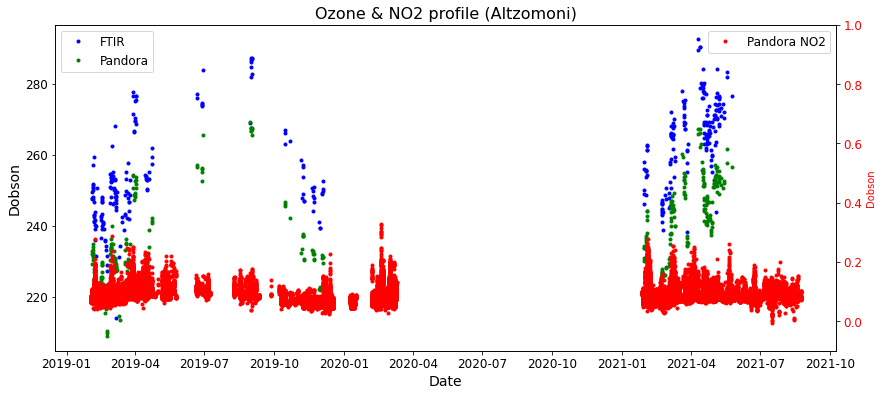

In [9]:
## pyplot plotting 
#x
#y

f, ax0 = plt.subplots(figsize=(14,6))
ax0.plot(coinc_hr_mean.index, coinc_hr_mean['o3column'], '.b', label='FTIR')
ax0.plot(coinc_hr_mean.index, coinc_hr_mean['ozone'], '.g', label='Pandora')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax0.set_xlabel('Date',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Dobson',size=14)
ax0.set_title("Ozone & NO2 profile (Altzomoni)",size=16)
ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)

ax2 = ax0.twinx() 
  
color = 'r'
ax2.set_ylim([-.1,1])
ax2.set_ylabel('Dobson', color = color) 
ax2.plot(panno2ts.index, panno2ts['no2'], '.r', label='Pandora NO2') 
ax2.tick_params(axis ='y',labelsize=12, labelcolor = color) 
ax2.legend(fontsize=12, loc='upper right')

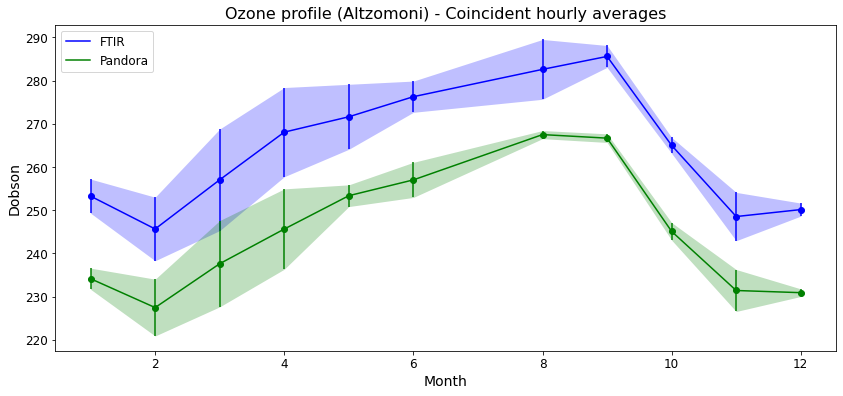

In [10]:


x=coinc_hr_mean.o3column.groupby(coinc_hr_mean.index.month).mean().index
y1=coinc_hr_mean.o3column.groupby(coinc_hr_mean.index.month).mean()
y1err=coinc_hr_mean.o3column.groupby(coinc_hr_mean.index.month).std()
y2=coinc_hr_mean.ozone.groupby(coinc_hr_mean.index.month).mean()
y2err=coinc_hr_mean.ozone.groupby(coinc_hr_mean.index.month).std()

f, ax0 = plt.subplots(figsize=(14,6))
ax0.plot(x, y1, '-b', label='FTIR')
ax0.plot(x, y2, '-g', label='Pandora')
ax0.fill_between(x, y1-y1err, y1+y1err,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
ax0.fill_between(x, y2-y2err, y2+y2err,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
ax0.errorbar(x, y1, yerr=y1err, fmt='bo')
ax0.errorbar(x, y2, yerr=y2err, fmt='go')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax0.set_xlabel('Month',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Dobson',size=14)
ax0.set_title("Ozone profile (Altzomoni) - Coincident hourly averages",size=16)
ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)

In [11]:
##### trying to detect outliers

In [12]:
ftirts_dy_mean=ftirts.resample('D').mean().dropna()
ftirts_dy_std=ftirts.resample('D').std().dropna()
ftirts_coinc_dy=pd.merge(ftirts_dy_mean,ftirts_dy_std,left_index=True,right_index=True)

ftirts_hr_mean=ftirts.resample('H').mean().dropna()
ftirts_hr_std=ftirts.resample('H').std().dropna()
ftirts_coinc_hr=pd.merge(ftirts_dy_mean,ftirts_dy_std,left_index=True,right_index=True)

ftirts_wk_mean=ftirts.resample('W', label='left').mean().dropna()
ftirts_wk_std=ftirts.resample('W', label='left').std().dropna()
ftirts_coinc_wk=pd.merge(ftirts_wk_mean,ftirts_wk_std,left_index=True,right_index=True)
ftirts_coinc_wk

,o3column_x,o3column_y
time,,
2012-10-21,250.641235,0.754452
2012-11-11,242.991806,5.322044
2012-11-18,240.764481,1.978751
2012-11-25,243.576859,6.222279
2012-12-02,244.842560,4.125345
...,...,...
2021-05-30,271.939819,1.675675
2021-06-20,275.951660,2.820465
2021-07-04,293.489136,1.704450


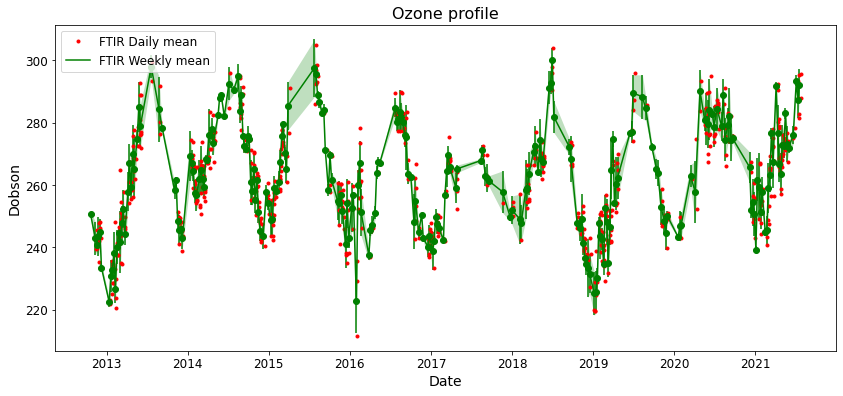

In [13]:

x1=ftirts_coinc_dy.index
y1=ftirts_coinc_dy.o3column_x
x2=ftirts_coinc_wk.index
y2=ftirts_coinc_wk.o3column_x
y2err=ftirts_coinc_wk.o3column_y

f, ax0 = plt.subplots(figsize=(14,6))
ax0.plot(x1, y1, '.r', label='FTIR Daily mean')
ax0.plot(x2, y2, '-g', label='FTIR Weekly mean')
ax0.fill_between(x2, y2-y2err, y2+y2err,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
ax0.errorbar(x2, y2, yerr=y2err, fmt='go')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax0.set_xlabel('Date',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Dobson',size=14)
ax0.set_title("Ozone profile",size=16)
ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)

In [14]:
ftirts_coinc_wk.index[3]
t0=dt.datetime.utcfromtimestamp(0.0)
tf=(ftirts_coinc_wk.index[0]-t0).total_seconds()
tft = dt.datetime.utcfromtimestamp(tf+5000)
print(ftirts_coinc_wk.index[2],ftirts_coinc_wk.index[3],tf,tft.year)
ty1=ftirts_coinc_wk.index[2].year
tm1=ftirts_coinc_wk.index[2].month
td1=ftirts_coinc_wk.index[2].day
ty2=ftirts_coinc_wk.index[3].year
tm2=ftirts_coinc_wk.index[3].month
td2=ftirts_coinc_wk.index[3].day

tempts=np.array(ftirts_hr_mean.o3column['%i-%02i-%02i' % (ty1,tm1,td1):'%i-%02i-%02i 00:00:00' % (ty2,tm2,td2)])
print(tempts)

tempts = ftirts_hr_mean['%i-%02i-%02i' % (ty1,tm1,td1):'%i-%02i-%02i 00:00:00' % (ty2,tm2,td2)]
tempts_zscore=(tempts.o3column-ftirts_coinc_wk.o3column_x[1])/ftirts_coinc_wk.o3column_y[1]
tempts_zscore

2012-11-18 00:00:00 2012-11-25 00:00:00 1350777600.0 2012
[244.74414 245.03362 245.99289 246.39868 246.41577 237.60196 239.76569
 241.85495 239.46457 240.3999  241.01111 242.39494 241.99896 243.77618
 237.79616 240.95694]


time
2012-11-18 13:00:00    0.329260
2012-11-18 14:00:00    0.383651
2012-11-18 15:00:00    0.563897
2012-11-18 16:00:00    0.640144
2012-11-18 17:00:00    0.643355
2012-11-19 13:00:00   -1.012740
2012-11-19 14:00:00   -0.606181
2012-11-19 15:00:00   -0.213613
2012-11-24 15:00:00   -0.662760
2012-11-24 16:00:00   -0.487013
2012-11-24 17:00:00   -0.372169
2012-11-24 18:00:00   -0.112149
2012-11-24 20:00:00   -0.186553
2012-11-24 21:00:00    0.147383
2012-11-24 22:00:00   -0.976251
2012-11-24 23:00:00   -0.382347
Name: o3column, dtype: float32

In [17]:
zscorefilter=np.abs(tempts_zscore)>1
#tempts[zscorefilter]
tempts3 = pd.concat([tempts2, tempts[zscorefilter]], axis= 0)
tempts3

,o3column
time,
2012-11-19 13:00:00,237.601959
2012-11-19 13:00:00,237.601959


In [16]:
tempts2=tempts[zscorefilter]

In [18]:
for ii,ele in enumerate(ftirts_coinc_wk.index):
    ty1=ele.year
    tm1=ele.month
    td1=ele.day
    try:
        ty2=ftirts_coinc_wk.index[ii+1].year
        tm2=ftirts_coinc_wk.index[ii+1].month
        td2=ftirts_coinc_wk.index[ii+1].day
    except:
        t0=dt.datetime.utcfromtimestamp(0.0)
        tf=(ftirts_coinc_wk.index[ii]-t0).total_seconds()
        t_endofweek=dt.datetime.utcfromtimestamp(tf+604800)
        ty2=t_endofweek.year
        tm2=t_endofweek.month
        td2=t_endofweek.day
    tempts = ftirts_hr_mean['%i-%02i-%02i' % (ty1,tm1,td1):'%i-%02i-%02i 00:00:00' % (ty2,tm2,td2)]
    tempts_zscore = (tempts.o3column-ftirts_coinc_wk.o3column_x[ii])/ftirts_coinc_wk.o3column_y[ii]
    zscorefilter = np.abs(tempts_zscore)>3
    if ii!=0:
        ftirts_outliers = pd.concat([ftirts_outliers, tempts[zscorefilter]], axis= 0)
    else:
        ftirts_outliers = tempts[zscorefilter]
    

In [19]:
ftirts_outliers.shape

(56, 1)

(200.0, 340.0)

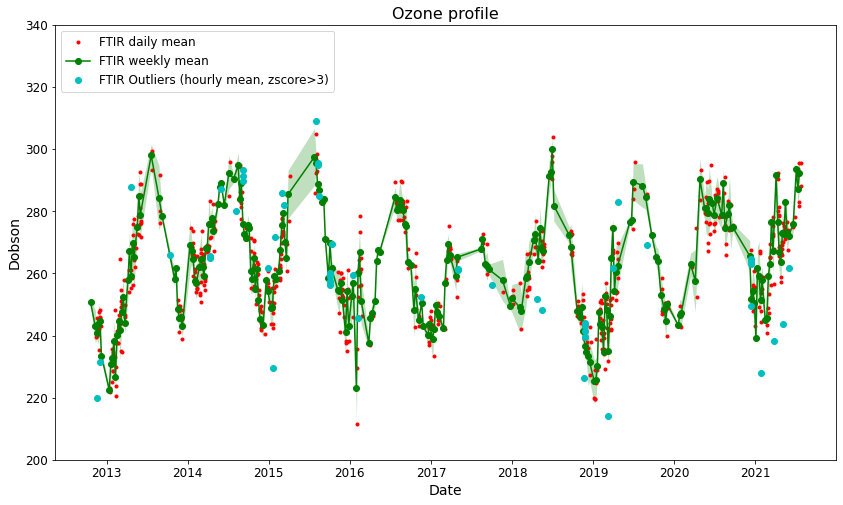

In [20]:
x1=ftirts_coinc_dy.index
y1=ftirts_coinc_dy.o3column_x
x2=ftirts_coinc_wk.index
y2=ftirts_coinc_wk.o3column_x
y2err=ftirts_coinc_wk.o3column_y
x3=ftirts_outliers.index
y3=ftirts_outliers.o3column

f, ax0 = plt.subplots(figsize=(14,8))

ax0.plot(x1, y1, '.r', label='FTIR daily mean')
ax0.plot(x2, y2, '-go', label='FTIR weekly mean')
ax0.plot(x3, y3, 'co', label='FTIR Outliers (hourly mean, zscore>3)')
ax0.fill_between(x2, y2-y2err, y2+y2err,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
#ax0.errorbar(x2, y2, yerr=y2err, fmt='go')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax0.set_xlabel('Date',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Dobson',size=14)
ax0.set_title("Ozone profile",size=16)
ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)
ax0.set_ylim([200,340])

In [22]:
#####OUTLIERS DE PANDORA NO2

Timestamp('2019-02-01 15:39:12')

In [24]:
panno2ts_dy_mean=panno2ts.no2.resample('D').mean().dropna()
panno2ts_dy_std=panno2ts.no2.resample('D').std().dropna()
panno2ts_coinc_dy=pd.merge(panno2ts_dy_mean,panno2ts_dy_std,left_index=True,right_index=True)

panno2ts_hr_mean=panno2ts.no2.resample('H').mean().dropna()
panno2ts_hr_std=panno2ts.no2.resample('H').std().dropna()
panno2ts_coinc_hr=pd.merge(panno2ts_dy_mean,panno2ts_dy_std,left_index=True,right_index=True)

panno2ts_wk_mean=panno2ts.no2.resample('W', label='left').mean().dropna()
panno2ts_wk_std=panno2ts.no2.resample('W', label='left').std().dropna()
panno2ts_coinc_wk=pd.merge(panno2ts_wk_mean,panno2ts_wk_std,left_index=True,right_index=True)
panno2ts_coinc_wk

,no2_x,no2_y
dtime,,
2019-01-27,0.089579,0.013649
2019-02-03,0.086196,0.023918
2019-02-10,0.086684,0.018418
2019-02-17,0.083816,0.015381
2019-02-24,0.098641,0.033159
...,...,...
2021-07-25,0.096614,0.011670
2021-08-01,0.089599,0.009490
2021-08-08,0.086811,0.009211


In [27]:
for ii,ele in enumerate(panno2ts_coinc_wk.index):
    ty1=ele.year
    tm1=ele.month
    td1=ele.day
    try:
        ty2=panno2ts_coinc_wk.index[ii+1].year
        tm2=panno2ts_coinc_wk.index[ii+1].month
        td2=panno2ts_coinc_wk.index[ii+1].day
    except:
        t0=dt.datetime.utcfromtimestamp(0.0)
        tf=(panno2ts_coinc_wk.index[ii]-t0).total_seconds()
        t_endofweek=dt.datetime.utcfromtimestamp(tf+604800)
        ty2=t_endofweek.year
        tm2=t_endofweek.month
        td2=t_endofweek.day
    tempts = panno2ts_hr_mean['%i-%02i-%02i' % (ty1,tm1,td1):'%i-%02i-%02i 00:00:00' % (ty2,tm2,td2)]
    tempts_zscore = (tempts-panno2ts_coinc_wk.no2_x[ii])/panno2ts_coinc_wk.no2_y[ii]
    zscorefilter = np.abs(tempts_zscore)>3
    if ii!=0:
        panno2ts_outliers = pd.concat([panno2ts_outliers, tempts[zscorefilter]], axis= 0)
    else:
        panno2ts_outliers = tempts[zscorefilter]

In [41]:
ftirts_outliers.shape

(56, 1)

(0.0, 0.4)

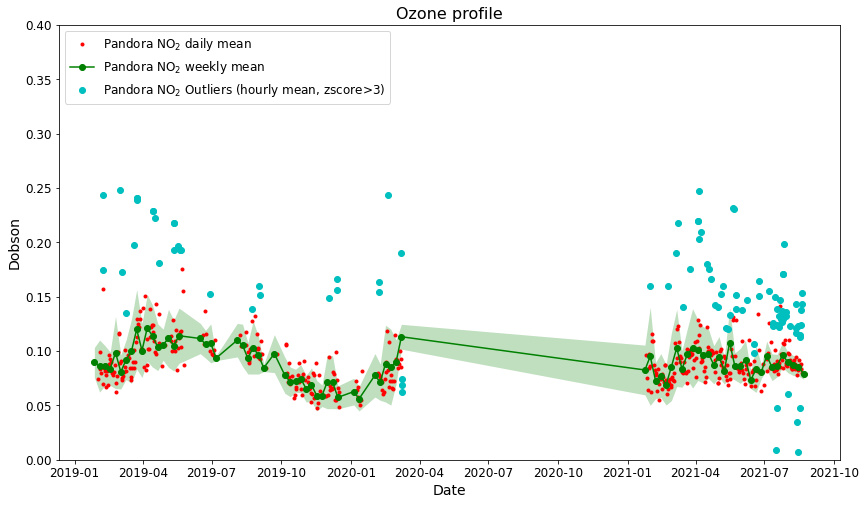

In [46]:
x1=panno2ts_coinc_dy.index
y1=panno2ts_coinc_dy.no2_x
x2=panno2ts_coinc_wk.index
y2=panno2ts_coinc_wk.no2_x
y2err=panno2ts_coinc_wk.no2_y
x3=panno2ts_outliers.index
y3=panno2ts_outliers

f, ax0 = plt.subplots(figsize=(14,8))

ax0.plot(x1, y1, '.r', label='Pandora NO$_2$ daily mean')
ax0.plot(x2, y2, '-go', label='Pandora NO$_2$ weekly mean')
ax0.plot(x3, y3, 'co', label='Pandora NO$_2$ Outliers (hourly mean, zscore>3)')
ax0.fill_between(x2, y2-y2err, y2+y2err,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
#ax0.errorbar(x2, y2, yerr=y2err, fmt='go')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax0.set_xlabel('Date',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Dobson',size=14)
ax0.set_title("Ozone profile",size=16)
ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)
ax0.set_ylim([0,.4])

In [73]:
panno2ts_outliers_dy_mean=panno2ts_outliers.resample('D').mean().dropna()
panno2ts_outliers_dy_std=panno2ts_outliers.resample('D').std().dropna()

ftirts_outliers_dy_mean=ftirts_outliers.resample('D').mean().dropna()
ftirts_outliers_dy_std=ftirts_outliers.resample('D').std().dropna()

outliers_coinc_dy=pd.merge(ftirts_outliers_dy_mean,panno2ts_outliers_dy_mean,left_index=True,right_index=True)
print(panno2ts_outliers_dy_mean.shape,ftirts_outliers_dy_mean.shape)
outliers_coinc_dy

(80,) (37, 1)


,o3column,no2
2021-05-04,243.86412,0.152229


Text(0.5, 1.0, 'Coincident outliers')

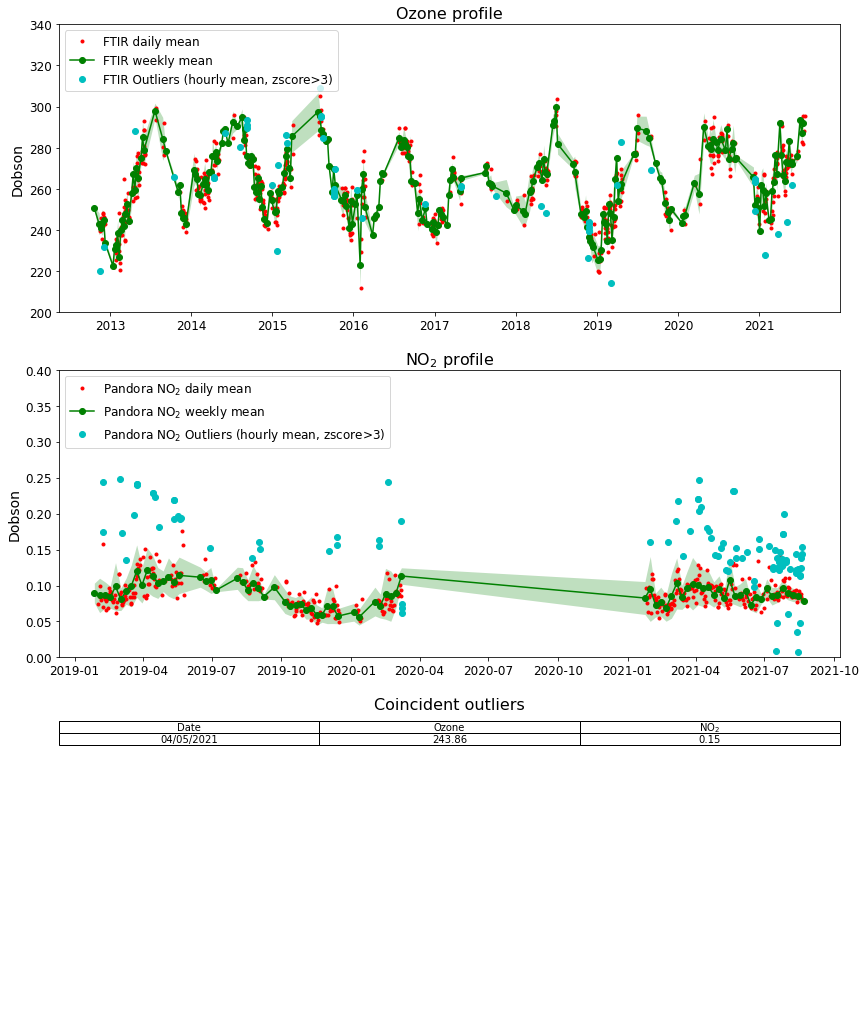

In [74]:
plt.figure(figsize=(14,18)) 

ax0 = plt.subplot(3, 1, 1) 
x1=ftirts_coinc_dy.index
y1=ftirts_coinc_dy.o3column_x
x2=ftirts_coinc_wk.index
y2=ftirts_coinc_wk.o3column_x
y2err=ftirts_coinc_wk.o3column_y
x3=ftirts_outliers.index
y3=ftirts_outliers.o3column

ax0.plot(x1, y1, '.r', label='FTIR daily mean')
ax0.plot(x2, y2, '-go', label='FTIR weekly mean')
ax0.plot(x3, y3, 'co', label='FTIR Outliers (hourly mean, zscore>3)')
ax0.fill_between(x2, y2-y2err, y2+y2err,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
#ax0.errorbar(x2, y2, yerr=y2err, fmt='go')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
#ax0.set_xlabel('Date',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Dobson',size=14)
ax0.set_title("Ozone profile",size=16)
ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)
ax0.set_ylim([200,340])



ax1 = plt.subplot(3, 1, 2) 
x1=panno2ts_coinc_dy.index
y1=panno2ts_coinc_dy.no2_x
x2=panno2ts_coinc_wk.index
y2=panno2ts_coinc_wk.no2_x
y2err=panno2ts_coinc_wk.no2_y
x3=panno2ts_outliers.index
y3=panno2ts_outliers

ax1.plot(x1, y1, '.r', label='Pandora NO$_2$ daily mean')
ax1.plot(x2, y2, '-go', label='Pandora NO$_2$ weekly mean')
ax1.plot(x3, y3, 'co', label='Pandora NO$_2$ Outliers (hourly mean, zscore>3)')
ax1.fill_between(x2, y2-y2err, y2+y2err,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
#ax0.errorbar(x2, y2, yerr=y2err, fmt='go')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
#ax1.set_xlabel('Date',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_ylabel('Dobson',size=14)
ax1.set_title("NO$_2$ profile",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
ax1.set_ylim([0,.4])

ax2 = plt.subplot(3, 1,3) 
table = outliers_coinc_dy
cell_text = []
tlabels = ['Date','Ozone','NO$_2$']
for row in range(len(table)):
    line = [table.index[row].strftime('%d/%m/%Y'),format(table.o3column[row], ".2f"),format(table.no2[row], ".2f")]
    cell_text.append(line)

ax2.table(cellText=cell_text, colLabels=tlabels,cellLoc='center', loc='upper center')
ax2.axis('off')
ax2.set_title("Coincident outliers",size=16)

In [71]:
panno2ts_outliers["2019-03-01":"2019-03-30"]

dtime
2019-03-01 18:00:00    0.248357
2019-03-03 23:00:00    0.172932
2019-03-09 23:00:00    0.134962
2019-03-20 23:00:00    0.197683
2019-03-23 23:00:00    0.239334
2019-03-24 00:00:00    0.241190
2019-03-24 00:00:00    0.241190
Name: no2, dtype: float64